# Procesamiento de Lenguaje Natural (PNL), Análisis de Sentimientos en Ingles

El datateset del cúal se hara uso, se encuentra en el siguiente enlace:

[Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/).

## Descargar y decomprimir archivos de internet con Python

|Librería|Funcionalidad|
|--------|-------------|
|os|Trabajar con el sistema operativo|
|sys|Manipular archivos (cortar, copiar, borrar, crear)|
|tarfile|Manipular archivos comprimidos|
|time|Calcular tiempo (en este caso de descarga)|

In [ ]:
import os
import sys
import tarfile
import time

In [ ]:
source = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

### Función para mostrar el proceso de descarga

In [ ]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d segundos transcurridos" % 
                     (percent, progress_size /(1024.**2), speed, duration))
    sys.stdout.flush()

### Descargar el archivo dentro de un directorio

In [ ]:
if not os.path.isdir('aclImdb') and not os.path.isfile('aclImdb_v1.tar.gz'):
    if (sys.version_info < (3,0)):
        import urllib
        urllib.urlretrieve(source, target, reporthook)
    else:
        import urllib.request
        urllib.request.urlretrieve(source, target, reporthook)

100% | 80 MB | 2.12 MB/s | 37 segundos transcurridos

En este caso hago uso de Colab de Google, el archivo se descarga de manera temporal, por lo que es recomendable enviarlo a Drive o a un equipo local.  

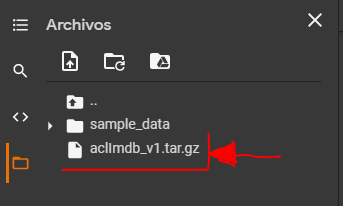

### Descomprimir el archivo

In [ ]:
if not os.path.isdir('aclImdb'):
    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()

El anterior script permite descomprimir el archivo dentro de un directorio, y este es el resultado. Dentro de train y test, se encuentran archivos de texto que contienen una por una, las críticas de las personas. Los creadores del dataset, las clasificaron ya en positivas y negaticas.

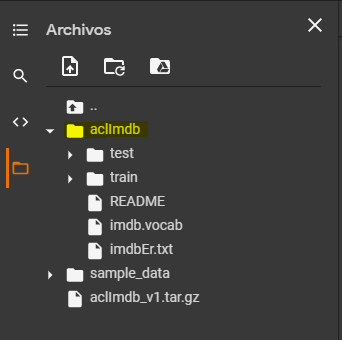

## Convertir los archivos descargados en un dataframe

### Librerías importante

Para poder visualizar el progreso de la tarea en ejucución en background, hacemos uso de la librería pyprind. Para instarla en un ordenador, ingresamos el siguiente comando por consola:
```
pip install pyprind
```
O en caso de que el entorno de colab no cuente con dicha librería, ingresamos el siguiente script:

In [ ]:
!pip install pyprind

In [ ]:
import pyprind
import pandas as pd

Es importante cambiar el directorio base a la carpeta que almacena nuestros datos. Con el siguiente script, permitimos que Python tome un path temporal que no afecte las variables de entorno del sistema operativo.

In [ ]:
basepath = 'aclImdb'

### Conversión en un dataset pandas

Creamos un diccionario, asignadole un valor a las carpetas pos y neg. Posteriormente, recorremos los directorios de test y train, en los cuales de encuentran los archivos, extrae las reviews, y las añade al dataframe asignandole al frente, el valor del sentimiento.

In [ ]:
labels = {'pos':1, 'neg':0}
pbar = pyprind.ProgBar(50000)

df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()

df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:51


Se realizan 50000 iteraciones(documentos), mediante bucles FOR interactuamos con los subdirectorios TRAIN y TEST y leemos los archivos de texto de forma individual de los subdirectorios POS y NEG y añadimos el dataframe de pandas una etiqueta de clase (1: Positivo, 0: Negativo)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### Permutar los datos

Los datos quedan divididos, la primera mitad, son los datos positivos, el resto son los datos negativos. Para barajar los datos, hacemos uso de la librería numpy

In [ ]:
import numpy as np

In [ ]:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

### Guardar los datos en un unico archivo CSV

Este paso es opcional, pero puede llegar a ser muy útil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/PLN_movie_data.csv', index=False, encoding='utf-8')

Lo siguiente es para comprobar si esta bien guardado

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN_movie_data.csv', encoding='utf-8')

In [ ]:
df.head(50000)

,review,sentiment
0,"John Carpenter's ""The Thing"" is undoubtedly on...",1
1,This movie attempts many things but never real...,0
2,"being a NI supporter, it's hard to objectively...",0
3,This film has a rotting core of flexible moral...,1
4,"""Indian burial ground"": If those three words a...",0
...,...,...
49995,Movies about U.F.O.'s are always a nice way to...,0
49996,(aka: DEMONS III)<br /><br />Made for Italian ...,0
49997,"I saw ""Myra Breckinridge"" when it first came o...",0
49998,Whatever happened to Keaton is what I want to ...,0


## Usar el modelo de bag-of-words

Primero se crea un vocabulario de componentes léxicos únicos (palabras únicas a partir de un conjunto de textos). 


Posteriormente se construye un vector de características a partir de cada documento que contiene el recuento de la frecuencia en que cada palabra aparece en el documento.

## Ejemplos de Vectorización

### Vectorización para un solo texto

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
new_text = ['Probando el CountVectorizer junto con un número: 123']
vector = CountVectorizer(stop_words=None)
vector.fit(new_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
print(vector.vocabulary_)

{'probando': 6, 'el': 3, 'countvectorizer': 2, 'junto': 4, 'con': 1, 'un': 7, 'número': 5, '123': 0}


Por medio de CountVectorizer, podemos optener un diccionario en el que se le asigna a cada palabra un índice según su orden en el abecedario.

### Vectorización para múltiples textos

In [ ]:
import numpy as np

count  = CountVectorizer()
docs = np.array(['The sun is shining', 
                 'The weather is sweet',
                 'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

In [ ]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [ ]:
import operator

count_dict = count.vocabulary_
count_sort = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=False)

for name in enumerate(count_sort):
    print(name[1][0], count_dict[name[1][0]])

and 0
is 1
one 2
shining 3
sun 4
sweet 5
the 6
two 7
weather 8


El método fit_transform construye el vocabulario del modelo y transforma en vectores los 3 elementos pasados en docs. Las palabras repetidas, solo se determinan una vez dentro del diccionario.

In [ ]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


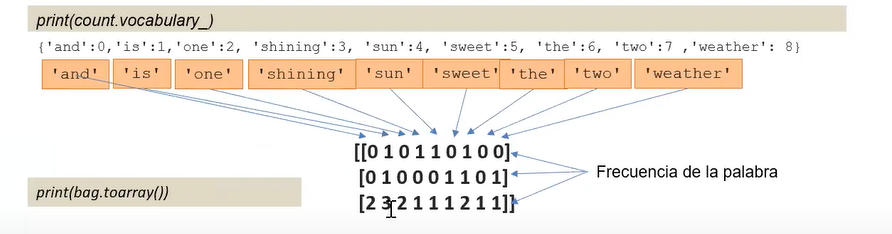

Cada posición de índice en los vecotes de características que se muestran aquí corresponde a los valores enteros que se almacenan como elementos de diccionario en el vocabulario CountVectorizer.

Esos valores en los vectores de características también se denominan *Frecuencias de terminos sin procesar* tf(t,d): El número de veces (d) que aparece un término (t) en cada posición de índice en los vectores de características.

Cuando analizamos datos textuales, a menudo encontramos palabras que aparecen en múltiples documentos. Normalmente estas palabras no contienen información útil o discriminatoria. Usaremos la técnica de termino-frecuencia inversa de documento *(TD-IDF frequency-inverse document frecuency)*, el cual se usa para bajar de peso a dichas palabras. 

$$ tf-idf(t,d) = td(t,d)*idf(t,d) $$

Donce, $tf(t,d)$ es la frecuencia de término y $idf(t,d)$ es la frecuencia inversa de documento y se calcula así:

$$ idf(t,d) = log \frac{n_d}{1+df(d,t)} $$

Donce, $n_d$ es el número total de documentos y $df(d,t)$ es el número de documentos $d$ que contiene el termino $t$. 

Scikit-learn implementa otro transformador, el *TfidfTransformer*, que toma las frecuencuas de término bruto de CounterVectorizer como entrada y las transforma en *tf-idfs*:

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
np.set_printoptions(precision=2)

In [ ]:
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


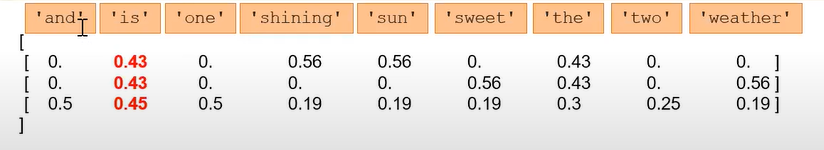

La palabra '***is***' tiene la frecuencia de término más grande en el tercer documento, siendo la palabra más frecuente. Sin embargo, después de transfomar el mismo vector de características en tf-idfs, vemos que la palabra 'is' ahora está asociada con un tf-idf relativamente pequeño (0.45) en el documento 3, ya que también está contenido en los documentos 1 y 2, por lo tanto, es poco probable que pueda contener infomación útil y discriminatoria. 

## Limpiar datos textuales.

### Preprocesamiento

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN_movie_data.csv', encoding='utf-8')

El texto contiene marcadores HTML, signos de puntación y otros marcadores alfabéticos. Procedemos a limpiar los marcadores HTML, pero dejamos los puntos, puesto que pueden representar información semántica útil.

In [ ]:
import re

In [ ]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ''.join(emoticons).replace('-', ''))
    return text

Este es un ejemplo de como queda cambiado

In [ ]:
print(df.loc[0, 'review'][-50:])

asterpiece of terror that will never be forgotten.


In [ ]:
print(preprocessor(df.loc[0, 'review'][-50:]))

asterpiece of terror that will never be forgotten 


Ahora aplicamos el preprocesador a todo el dataset

In [ ]:
df['review'] = df['review'].apply(preprocessor)

### Tokenizar

Una vez se teng la seguridad de que los datos están limpios, se procede a convertir el dataset en palabras individuales, tomando como método los espacios entre las palabras.

In [ ]:
def tokenizer(text):
    return text.split()

In [ ]:
tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

Existe una técnica llamada 'declinación de palabras' o 'algortimo de Porter' que permite mapear las palabras, pero tomando la raíz de la palabra

In [ ]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

En cuanto a algoritmos de declinación el "algoritmo Porter" es uno de los más antiguos y más sencillos, pero no el más eficiente. Existen unos mejores como Snowball (porter2 o en ingles, stemmer) y el Lancaster (paice/ husk stemmer). Para usarlos es necesario instalar el paquete nltk con el comando:

```
pip install nltk
```

Una vez instalado, se debe descargar los componentes necesarios para trabajar con NLTK

In [ ]:
import nltk

In [ ]:
nltk.download('all')
nltk.download('popular')
nltk.download('stopwords')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

Una vez descargado los paquetes necesarios, podremos eliminar palabras vacías para el idioma ingles. 

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop = stopwords.words('english')

[w for w in tokenizer_porter('a runner likes running and runs a lot') if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

Como se puede observar, se ejecutan dos procesos:

- Tomar la raíz de las palabras
- Eliminar palabras que no son relevantes para el idioma ingles ('a' y 'and')

## Definir y entrenar un modelo de Regresión Logística. 

Definimos las librerías y paquetes que necesitaremos, en este caso usaremos la librería llamada GridSearchSV para encontrar el conjunto de parámetros óptimo para nuestro modelo de regresión logística mediante una validación cruzada de 5 iteraciones. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

|Librería|Uso|
|--------|---|
|Pipeline|Permite implementar métodos de ajuste y transformación|
|LogisitcRegression|Modelo de Regresión Logística|
|TfidfVectorizer|Conversor de texto a vector|
|GridSearchCV|Búsqueda de cuadrícula con validación cruzada (para usar con regresión logística)|

Dividiremos el dataset en 25000 para entrenar y 25000 para testear.

In [ ]:
x_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values

In [ ]:
x_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment']

Le definimos los parámetros globales para hacer la regresión logística, primero que convierta una colección de documentos en bruto en una matriz de características TF-IDF.

***TfidfVectorizer*** hace lo mismo que ***CountVectorizer*** y ***Tfidftransformer***

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Propiedades del conversor de texto a vectores

In [ ]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

Lo anterior nos permite tener una base de como queremos que realice la vectorización del texto:

- No definir un preprocesador -> preprocessor=None (none, ya que usamos uno atras)
- No poner todas las letras en minúscula -> lowercase=False
- No eliminar los acentos -> strip_accents=None

La eliminación de los acentos se usa en idiomas como el español donde los acentos son muy frecuentes. Para la eliminación y normalización de caracteres durante el preprocesamiento. Existen varias opciones: 

- 'ascii' es un método rápido que solo funciona en caracteres que contienen un mapeo ASCII directo.
- 'unicode' es un método un poco más lento que funciona en cualquier personaje.
- 'None', Ninguno(predeterminado) no hace nada.

### Cuadrícula de validaciones (Hyperparameters)

Creamos 2 diccionarios:

- El primero: *use_idf=True*, *smoth_idf=True* y *norm='l2'*, que se usarán para calcualar los tf-idf

- El segundo: *use_idf=False*, *smoth_idf=False* y *norm=None*, para entrenar un modelo basado en frecuencias de términos sin procesar. Para usar la regresión logística debemos usar L1 y L2 mediante parámetros de penalización y adicionalmente comparamos diferentes fuerzas de regulación definiendo un rango de valores para el parámetro de regulación inversa C.

In [ ]:
param_grid = [
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
               
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf': [False],
               'vect__norm': [None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}
]

### Pipeline

Creamos un Pipeline, que es lo que encadena varios pasos juntos, una vez que se realiza la exploración inicial. Por ejemplo: 

- Puede transformar características: normalizar números, convertir texto en vectores o completar datos faltantes(nuestro caso), son transformadores.
- Predecir variables ajustando un algoritmo, como "Random Forest" o "Support Vector Machine", son estimadores. 

Mezclamos regresión lineal y vectores de textos en un solo proceso

In [ ]:
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))])

Creamos la búsqueda de cuadrícula (GridSearchCV), cuyo propósito es un enfoque para el ajuste de parámetros que construirá y evaluará metódicamente un modelo para cada combinación de parámetros de algoritmo especificados en una cuadrícula.

In [ ]:
gs_lr_tfidf = GridSearchCV(
    lr_tfidf, 
    param_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=1,
    n_jobs=-1
)

El parámetro *n_jobs=-1* permite que el interprete de Python utilice todos los procesadores disponibles en el sistema. Es importante hacer la aclaración de que no es recomendable hacer este proceso directamente en Windows, pues puede generar errores en la declinación de palabras, además de presentar fallos en el sistema. Es preferible hacer la ejecución en un entorno virtual como Colab, o en sistemas operativos como Linux o MacOS.

### Entrenamiento

Una vez terminamos de definir todos los parámetros necesarios, procedemos a entrenar nuestros modelos. 

In [ ]:
gs_lr_tfidf.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 39.8min


En caso de que queramos reducir el tiempo de ejecución podemos cambiar unos Hyperparametros, pero esto afectara en la precisión del mismo. Entonces, si así lo queremos, eliminamos el segundo diccionario de param_grid, dejando solo de la siguiente manera:

```python
param_grid = [
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}
]
```

### Ver resultados

Una vez terminada la búsqueda de cuadrícula, imprimimos el mejor conjunto de parámetros:

In [ ]:
print('Mejores set de parametros: %s' % gs_lr_tfidf.best_params_)

In [ ]:
print('CV exactitud: %.3f' % gs_lr_tfidf.best_score_)

Una vez terminada la búsqueda de cuadrícula, imprimimos el mejor conjunto de parámetros:

In [ ]:
clf = gs_lr_tfidf.best_estimator_
print('Test exactitud: %.3f' % clf.score(x_test, y_test))

## Serialización del modelo de IA

In [ ]:
import pickle
import os

Para guardar los archivos serializados, se crea una nueva carpeta

In [ ]:
dest = os.path.join('/content/drive/MyDrive/Colab Notebooks/PLN/moviesclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

Convertimos el clasificador y el stopword en archivo/objetos_pkl

In [ ]:
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Los serializables los podemos usar por ejemplo, para ser publicados y usados en una página web, tal es el caso de uso que se dio en github. 